In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [215]:
# pip install pyarrow
# pip install fastparquet

In [216]:
# https://figshare.com/articles/dataset/A_public_dataset_on_long-distance_running_training_in_2019_and_2020/16620238
data = pd.read_parquet('run_ww_2019_d.parquet')

## Data observations

In [217]:
data.head()
## some lines contain zeroes - the db contains each day of the year for every athlete, regardles of the
## actual training 

,datetime,athlete,distance,duration,gender,age_group,country,major
0,2019-01-01,0,0.00,0.00,F,18 - 34,United States,CHICAGO 2019
1,2019-01-01,1,5.27,30.20,M,35 - 54,Germany,BERLIN 2016
2,2019-01-01,2,0.00,0.00,M,35 - 54,United Kingdom,"LONDON 2018,LONDON 2019"
3,2019-01-01,3,10.50,43.95,M,18 - 34,United Kingdom,LONDON 2017
4,2019-01-01,4,9.66,48.65,M,35 - 54,United States,BOSTON 2017


In [218]:
data.shape
print('We have {} entries in our training dataset.'.format(data.shape[0]))
print('For {} athletes.'.format(data['athlete'].nunique()))

We have 13290380 entries in our training dataset.
For 36412 athletes.


In [219]:
data = data[(data['distance']>0)&(data['duration']>0)]
print('Down to {} trainings after we exclude non-training days'.format(data.shape[0]))

Down to 4677389 trainings after we exclude non-training days


In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677389 entries, 1 to 13290379
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   datetime   datetime64[ns]
 1   athlete    int64         
 2   distance   float64       
 3   duration   float64       
 4   gender     object        
 5   age_group  object        
 6   country    object        
 7   major      object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 321.2+ MB


In [221]:
data['major'].value_counts()
## some majors relate to previous years, some are aggregated

BOSTON 2019                            611295
BERLIN 2019                            478580
BOSTON 2018                            280279
BERLIN 2018                            265114
NEW YORK 2019                          259502
                                        ...  
BERLIN 2014,TOKYO 2015                      2
BERLIN 2016,BOSTON 2014,BOSTON 2016         2
BOSTON 2016,NEW YORK 2013                   1
TOKYO 2014,TOKYO 2018                       1
NEW YORK 2015,NEW YORK 2016                 1
Name: major, Length: 1332, dtype: int64

In [222]:
## 'athlete' should be categorical
data['athlete']=data['athlete'].astype('object')

In [223]:
long_dist=data[data['distance']>42]['datetime'].count()
print('{} entries with distances over 42 km -- could they be actual marathons?'.format(long_dist))

60315 entries with distances over 42 km -- could they be actual marathons?


## 2019 Berlin marathon data

Distribution of distance for the day of the Berlin marathon in our db:


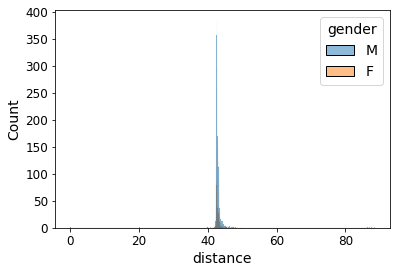

In [224]:
## lets select the biggest major and relevant athletes -> 2019 Berlin marathon
## we discard Boston as this event is only for qualified participants 
## lets see if we have entries for the actual Berlin marathon
## marathon_city='BERLIN 2019'
## marathon_date='30.09.2019'
## we check the right date first 
## what was the distances for this day?

print('Distribution of distance for the day of the Berlin marathon in our db:')

event_db = data[(data['datetime']=='29.09.2019')&(data['major']=='BERLIN 2019')].copy()
sns.histplot(x='distance',hue='gender',data=event_db)
plt.savefig('bm2019dist_dist.png')
plt.show()

## so everything is clustered around 42 km, but we need to narrow the selection

In [225]:
bm_num=event_db['athlete'].nunique()
print('The db countains results of Berlin marathon for {} athletes.'.format(bm_num))

high_km_limit = 45
low_km_limit = 42

## ... and 21 peoples did not finished :( 
## or their tracker battery did not make it
bm_dsq = event_db[(event_db['distance']<low_km_limit)]['athlete'].count()
print('We exlude {} people due to low mileage.'.format(bm_dsq))
bm_err = event_db[(event_db['distance']>high_km_limit)]['athlete'].count()
print('We also exlude {} people due to unexpectedly high mileage.'.format(bm_err))

# this variable is a dataframe with the results of Berlin marathon
event_db = event_db[(event_db['distance']>low_km_limit)&
                      (event_db['distance']<high_km_limit)]

bm_num_42=event_db['athlete'].nunique()
print('{} athletes have running distance of more than {} km and less than {} km.'.format(bm_num_42,low_km_limit,high_km_limit))

The db countains results of Berlin marathon for 3796 athletes.
We exlude 21 people due to low mileage.
We also exlude 101 people due to unexpectedly high mileage.
3674 athletes have running distance of more than 42 km and less than 45 km.


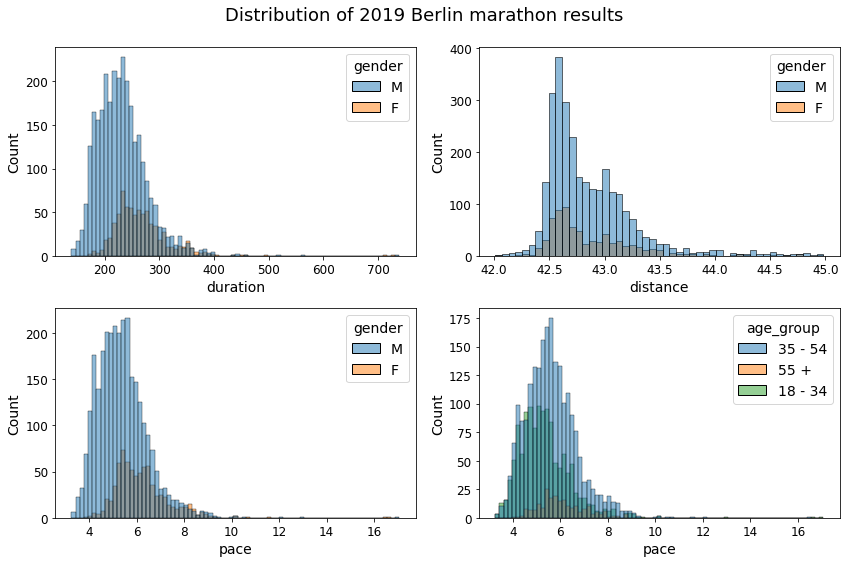

In [226]:
## lets check the duraton and distance distributions (this is still Berlin marathon)
## also i want to see the pace

event_db['pace']=event_db['duration']/event_db['distance']

fig, axs = plt.subplots(2, 2, sharex=False, figsize=(12, 8))

sns.histplot(ax=axs[0,0], x='duration',hue='gender',data=event_db)
sns.histplot(ax=axs[0,1],  x='distance',hue='gender',data=event_db)
sns.histplot(ax=axs[1,0],  x='pace',hue='gender',data=event_db)
sns.histplot(ax=axs[1,1],  x='pace',hue='age_group',data=event_db)

plt.suptitle('Distribution of 2019 Berlin marathon results', fontsize=18)

plt.tight_layout(h_pad=1)
plt.savefig('bm2019results.png')
plt.show()


In [227]:
## probaly we need to cut this long tail for pace and set max duration of 7 hours
event_db = event_db[(event_db['duration']<420)&(event_db['pace']<10)]
bm_num_42 = event_db['athlete'].nunique()
print('The number of athletes is reduced to {}.'.format(bm_num_42))

The number of athletes is reduced to 3661.


In [228]:
event_db.describe().round(2)

,distance,duration,pace
count,3661.00,3661.00,3661.00
mean,42.87,237.03,5.53
std,0.43,45.28,1.05
min,42.01,139.00,3.26
25%,42.58,205.00,4.79
50%,42.73,233.00,5.44
75%,43.05,263.00,6.14
max,44.98,404.00,9.45


In [229]:
## lets check the distribution of categoricals

print((event_db['age_group'].value_counts()/len(event_db)*100).round(2))
print((event_db['gender'].value_counts()/len(event_db)*100).round(2))

35 - 54    59.87
18 - 34    34.23
55 +        5.90
Name: age_group, dtype: float64
M    79.65
F    20.35
Name: gender, dtype: float64


## 2019 Berlin marathon training data

In [230]:
## selecting training entries with appropriate major and time interval
## data_berlin=data[(data['datetime']<'29.09.2019')&(data['major'].str.contains('BERLIN 2019'))]
train_db=data[(data['datetime']<'29.09.2019')&(data['major']=='BERLIN 2019')].copy()
del data

bm_train=train_db['datetime'].count()
print('We have info abount {} trainings for {} participants of 2019 Berlin marathon.'
      .format(bm_train,train_db['athlete'].nunique()))


We have info abount 371661 trainings for 3788 participants of 2019 Berlin marathon.


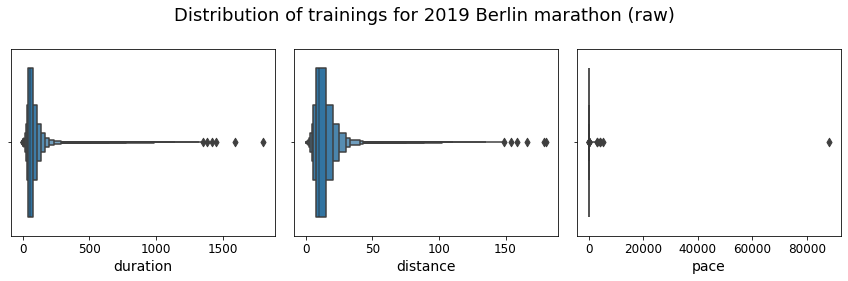

In [231]:
## lets check the distribution of data to see if we have outliers
## also we need to add pace

train_db['pace']=(train_db['duration']/train_db['distance']).round(2)

fig, axs = plt.subplots(1, 3, sharex=False, figsize=(12, 4))

sns.boxenplot(ax=axs[0], x='duration', data=train_db)
sns.boxenplot(ax=axs[1], x='distance', data=train_db)
sns.boxenplot(ax=axs[2], x='pace',     data=train_db)

plt.suptitle('Distribution of trainings for 2019 Berlin marathon (raw)', fontsize=18)

plt.tight_layout(h_pad=1)
plt.savefig('dist_train_raw.png')
plt.show()


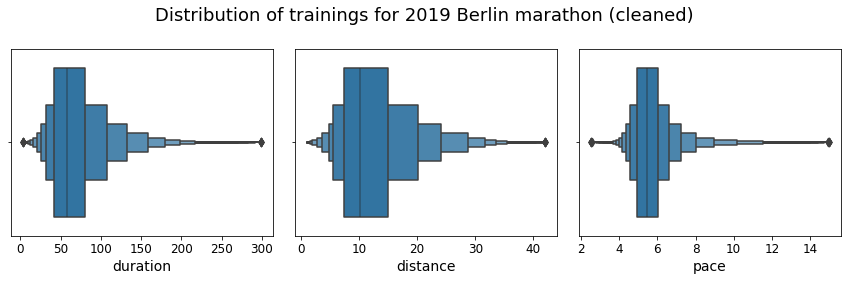

,datetime,athlete,distance,duration,gender,age_group,country,major,pace
65,2019-01-01,69,2.34,13.266667,M,18 - 34,Russia,BERLIN 2019,5.669516
73,2019-01-01,77,10.01,55.433333,M,35 - 54,Taiwan,BERLIN 2019,5.537796
125,2019-01-01,134,12.97,89.000000,M,35 - 54,Poland,BERLIN 2019,6.861989
172,2019-01-01,182,8.00,39.150000,M,18 - 34,Russia,BERLIN 2019,4.893750
243,2019-01-01,257,8.00,43.450000,M,35 - 54,France,BERLIN 2019,5.431250
...,...,...,...,...,...,...,...,...,...
9867417,2019-09-28,37349,11.01,57.216667,M,35 - 54,Russia,BERLIN 2019,5.196791
9867446,2019-09-28,37379,7.88,73.600000,M,35 - 54,Ukraine,BERLIN 2019,9.340102
9867551,2019-09-28,37494,4.85,24.616667,F,35 - 54,United Kingdom,BERLIN 2019,5.075601
9867568,2019-09-28,37513,4.19,34.266667,M,35 - 54,United Kingdom,BERLIN 2019,8.178202


In [232]:
## we are removing:
## - training distances less then 1 km and above 50 km 
## - pace faster then 2.5 min/km and slower then 15 min/km
## - duration less then 1 min and longer then 5 hours
train_db = train_db[(train_db['distance']>1)&
                   (train_db['distance']<42)&
                   (train_db['pace']>2.5)&
                   (train_db['pace']<15)&
                   (train_db['duration']>1)&
                   (train_db['duration']<300)]


train_db['pace']=train_db['duration']/train_db['distance']

fig, axs = plt.subplots(1, 3, sharex=False, figsize=(12, 4))

sns.boxenplot(ax=axs[0], x='duration', data=train_db)
sns.boxenplot(ax=axs[1], x='distance', data=train_db)
sns.boxenplot(ax=axs[2], x='pace', data=train_db)

plt.suptitle('Distribution of trainings for 2019 Berlin marathon (cleaned)', fontsize=18)

plt.tight_layout(h_pad=1)
plt.savefig('dist_train_clean.png')
plt.show()

train_db

In [233]:
## now lets collect training data for every marathoner in our list

dummy_db = train_db[["athlete","distance","duration"]].groupby("athlete").agg(
    {'athlete':'count','distance':sum,'duration':sum})
dummy_db.columns = ['tr_num', 'tr_dist_tot', 'tr_dur_tot']

marathon=event_db.merge(dummy_db, on='athlete', how = 'inner')
marathon['tr_num']=marathon['tr_num'].astype('Int64')
marathon['tr_dist_tot']=marathon['tr_dist_tot'].round(1)
marathon['tr_dur_tot']=marathon['tr_dur_tot'].round(1)

del dummy_db
print('{} athletes after inner join.'.format(marathon.shape[0]))
marathon.head()

3650 athletes after inner join.


,datetime,athlete,distance,duration,gender,age_group,country,major,pace,tr_num,tr_dist_tot,tr_dur_tot
0,2019-09-29,14,42.98,163.0,M,35 - 54,Spain,BERLIN 2019,3.792462,203,2368.4,11237.6
1,2019-09-29,30,43.25,232.0,M,55 +,Netherlands,BERLIN 2019,5.364162,51,910.9,5636.0
2,2019-09-29,40,43.64,299.0,F,35 - 54,Netherlands,BERLIN 2019,6.851512,15,155.3,1048.1
3,2019-09-29,69,42.81,267.0,M,18 - 34,Russia,BERLIN 2019,6.236861,111,1086.6,6476.5
4,2019-09-29,77,42.69,282.0,M,35 - 54,Taiwan,BERLIN 2019,6.605762,122,1241.2,7422.8


In [234]:
marathon['tr_pace_avg']=marathon['tr_dur_tot']/marathon['tr_dist_tot'].round(1)
marathon['tr_dist_avg']=marathon['tr_dist_tot']/marathon['tr_num'].round(1)

In [235]:
marathon.describe().round(1)

,distance,duration,pace,tr_num,tr_dist_tot,tr_dur_tot,tr_pace_avg,tr_dist_avg
count,3650.0,3650.0,3650.0,3650.0,3650.0,3650.0,3650.0,3650.0
mean,42.9,236.9,5.5,96.3,1150.0,6341.5,5.7,11.7
std,0.4,45.3,1.0,50.9,729.2,3666.1,0.8,2.5
min,42.0,139.0,3.3,1.0,3.0,16.8,3.6,3.0
25%,42.6,205.0,4.8,59.0,632.8,3713.0,5.1,10.1
50%,42.7,233.0,5.4,93.0,1033.2,5905.2,5.6,11.6
75%,43.0,263.0,6.1,127.0,1482.4,8277.4,6.1,13.2
max,45.0,404.0,9.5,269.0,5276.6,26178.8,10.4,27.8


In [236]:
## more data cleaning

marathon=marathon[marathon['tr_num']>20]
marathon=marathon[marathon['tr_pace_avg']<10]
marathon=marathon[marathon['tr_dist_tot']>100]
marathon=marathon[marathon['tr_dist_avg']<30]
marathon.describe().round(1)

,distance,duration,pace,tr_num,tr_dist_tot,tr_dur_tot,tr_pace_avg,tr_dist_avg
count,3443.0,3443.0,3443.0,3443.0,3443.0,3443.0,3443.0,3443.0
mean,42.9,235.9,5.5,101.4,1210.8,6674.4,5.7,11.7
std,0.4,44.8,1.0,47.8,705.8,3504.2,0.8,2.4
min,42.0,139.0,3.3,21.0,132.8,718.6,3.9,3.9
25%,42.6,204.0,4.8,66.0,708.8,4080.0,5.1,10.1
50%,42.7,232.0,5.4,97.0,1069.4,6133.4,5.6,11.6
75%,43.0,261.0,6.1,129.0,1525.9,8446.3,6.1,13.2
max,45.0,404.0,9.3,269.0,5276.6,26178.8,10.0,22.4


In [237]:
print('Number of individuals is now {}.'.format(marathon.shape[0]))

Number of individuals is now 3443.


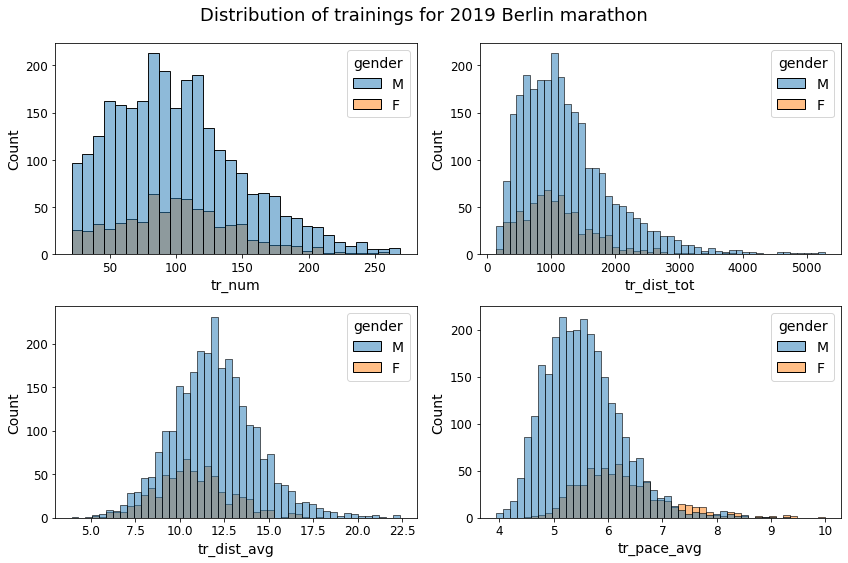

In [238]:
fig, axs = plt.subplots(2, 2, sharex=False, figsize=(12, 8))

sns.histplot(ax=axs[0,0], x='tr_num',hue='gender',data=marathon)
sns.histplot(ax=axs[0,1], x='tr_dist_tot',hue='gender',data=marathon)
sns.histplot(ax=axs[1,0], x='tr_dist_avg',hue='gender',data=marathon)
sns.histplot(ax=axs[1,1], x='tr_pace_avg',hue='gender',data=marathon)

plt.suptitle('Distribution of trainings for 2019 Berlin marathon', fontsize=18)

plt.tight_layout(h_pad=1)
plt.savefig('dist_train_gender.png')
plt.show()


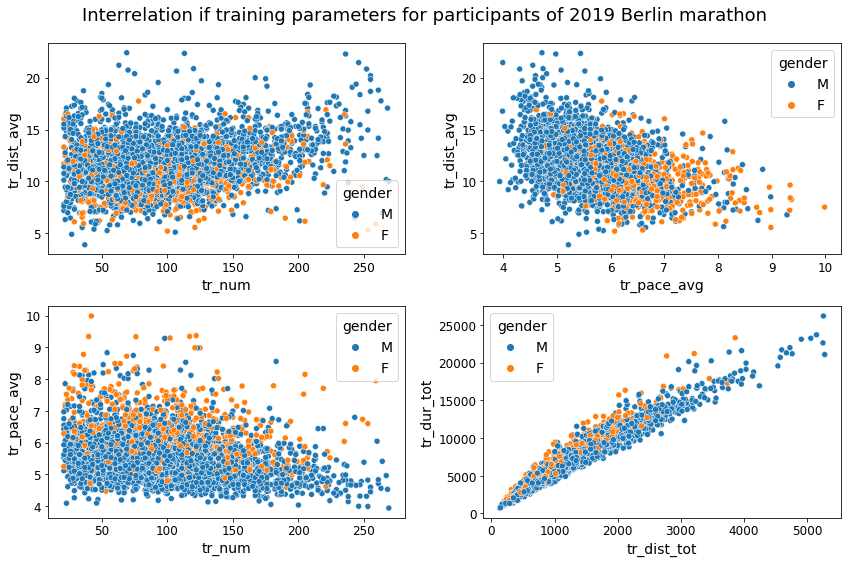

In [239]:
fig, axs = plt.subplots(2, 2, sharex=False, figsize=(12, 8))

sns.scatterplot(ax=axs[0,0], y='tr_dist_avg',x='tr_num',hue='gender',data=marathon)
sns.scatterplot(ax=axs[0,1], y='tr_dist_avg',x='tr_pace_avg',hue='gender',data=marathon)
sns.scatterplot(ax=axs[1,0], y='tr_pace_avg',x='tr_num',hue='gender',data=marathon)
sns.scatterplot(ax=axs[1,1], x='tr_dist_tot',y='tr_dur_tot',hue='gender',data=marathon)

plt.suptitle('Interrelation if training parameters for participants of 2019 Berlin marathon', fontsize=18)

plt.tight_layout(h_pad=1)
plt.savefig('dist_train_scatter.png')
plt.show()


## Training analysis

In [240]:
## lets see how the training is happening during the year

grouper = pd.Grouper(axis=1, key='datetime', freq='m', sort=True)
x = train_db[['athlete', 'datetime', 'distance','duration']].groupby(['athlete', grouper],
                                                observed=False, dropna=False).sum()
y = train_db[['athlete', 'datetime', 'distance']].groupby(['athlete', grouper],
                                                observed=False, dropna=False).count()
x['tr_num'] = y['distance']
x = x.unstack(level=1).round(2)

## make sure that the athlets are the same
marathon_index = marathon['athlete'].tolist()
x_index = x.index
mask = x_index.isin(marathon_index)
x = x.loc[mask]

print(x.shape)
x.head()

(3443, 27)


distance                                                         \
datetime 2019-01-31 2019-02-28 2019-03-31 2019-04-30 2019-05-31 2019-06-30   
athlete                                                                      
14           277.30     282.61     285.06     160.18     245.91     239.43   
30           142.09     113.25      25.93     107.08     127.58      90.97   
69            44.51      63.90     101.18      57.75     107.44     197.70   
77           138.36     117.47      82.30      87.08     142.50     143.64   
102           95.75      75.70     101.57      94.14     109.95     171.13   

                                            duration  ...             \
datetime 2019-07-31 2019-08-31 2019-09-30 2019-01-31  ... 2019-09-30   
athlete                                               ...              
14           315.81     332.59     229.51    1258.48  ...    1032.57   
30            79.27     125.42      99.33     895.72  ...     597.98   
69           182.76     251.30      80.03     277.23  ...     440.23   
77           181.15     183.77     164.95     850.07  ...     998.35   
102          153.25     153.44     111.12     782.60  ...     870.57   

             tr_num                                                         \
datetime 2019-01-31 2019-02-28 2019-03-31 2019-04-30 2019-05-31 2019-06-30   
athlete                                                                      
14             22.0       21.0       22.0       20.0       27.0       23.0   
30              8.0        5.0        2.0        6.0        9.0        4.0   
69              6.0        8.0       12.0        8.0       11.0       19.0   
77             14.0       12.0        9.0        8.0       15.0       14.0   
102            13.0       11.0       18.0       14.0       14.0       18.0   

                                           
datetime 2019-07-31 2019-08-31 2019-09-30  
athlete                                    
14             24.0       26.0       18.0  
30              5.0        5.0        7.0  
69             18.0       21.0        8.0  
77             16.0       16.0       18.0  
102            16.0       15.0       17.0  

[5 rows x 27 columns]

In [241]:
## and we need to add pace as well

cols = x.columns
period_lst = cols.get_level_values("datetime")

for i in period_lst:
    x['pace',i]=(x['duration',i]/x['distance',i]).round(2)
print(x.shape)
x['pace'].head()

(3443, 36)


datetime,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30
athlete,,,,,,,,,
14,4.54,4.89,4.57,5.13,4.72,4.92,4.66,4.90,4.50
30,6.30,6.19,6.19,5.98,5.97,6.41,6.62,6.15,6.02
69,6.23,6.34,6.18,6.36,6.15,5.98,5.94,5.70,5.50
77,6.14,5.81,6.42,7.20,6.69,5.71,4.68,6.07,6.05
102,8.17,9.08,8.73,8.39,7.86,7.66,7.86,7.46,7.83


In [242]:
x=x[x.index.isin(marathon['athlete'])==True]
x.shape

(3443, 36)

In [243]:
x.describe().T.head(40).round(2)

count     mean     std    min     25%      50%      75%  \
         datetime                                                               
distance 2019-01-31  2843.0   128.80   97.78   1.01   57.23   105.92   176.43   
         2019-02-28  2928.0   123.25   90.95   1.75   55.67   103.28   168.04   
         2019-03-31  3034.0   139.34  100.39   1.98   64.30   120.03   191.71   
         2019-04-30  3111.0   120.47   83.31   1.02   61.40   104.91   160.26   
         2019-05-31  3195.0   126.99   86.08   1.04   65.32   111.46   169.12   
         2019-06-30  3282.0   138.63   88.17   1.17   75.03   124.01   182.69   
         2019-07-31  3365.0   167.13  100.16   1.11   96.38   152.14   219.72   
         2019-08-31  3416.0   198.60  105.73   4.86  126.44   186.27   250.56   
         2019-09-30  3428.0   158.29   78.38   3.66  104.94   149.03   201.40   
duration 2019-01-31  2843.0   709.29  499.20   5.52  336.72   613.43   973.44   
         2019-02-28  2928.0   674.33  461.33  11.68  325.53   582.44   936.38   
         2019-03-31  3034.0   761.34  511.36   9.60  365.67   675.58  1050.96   
         2019-04-30  3111.0   663.22  427.73   9.43  345.86   601.13   894.42   
         2019-05-31  3195.0   700.93  446.59   5.83  372.12   635.75   932.78   
         2019-06-30  3282.0   774.67  459.96   7.30  429.73   715.32  1037.90   
         2019-07-31  3365.0   929.00  511.60  12.25  555.02   877.32  1238.12   
         2019-08-31  3416.0  1096.08  522.70  22.08  733.76  1064.60  1400.44   
         2019-09-30  3428.0   864.56  384.21  23.02  605.12   840.22  1095.84   
tr_num   2019-01-31  2843.0    11.60    6.81   1.00    6.00    11.00    16.00   
         2019-02-28  2928.0    10.54    5.95   1.00    6.00    10.00    14.00   
         2019-03-31  3034.0    11.66    6.48   1.00    7.00    11.00    16.00   
         2019-04-30  3111.0    10.89    5.88   1.00    6.00    10.00    14.00   
         2019-05-31  3195.0    11.62    6.21   1.00    7.00    11.00    15.00   
         2019-06-30  3282.0    12.28    6.18   1.00    8.00    12.00    16.00   
         2019-07-31  3365.0    13.73    6.31   1.00    9.00    13.00    18.00   
         2019-08-31  3416.0    14.60    6.13   1.00   10.00    14.00    18.00   
         2019-09-30  3428.0    12.44    5.31   1.00    9.00    12.00    16.00   
pace     2019-01-31  2843.0     5.74    0.91   3.22    5.12     5.60     6.17   
         2019-02-28  2928.0     5.69    0.90   3.69    5.07     5.58     6.12   
         2019-03-31  3034.0     5.68    0.90   3.80    5.08     5.56     6.11   
         2019-04-30  3111.0     5.69    0.90   3.41    5.09     5.57     6.11   
         2019-05-31  3195.0     5.68    0.89   3.37    5.07     5.55     6.11   
         2019-06-30  3282.0     5.74    0.88   3.44    5.14     5.62     6.19   
         2019-07-31  3365.0     5.74    0.88   3.31    5.13     5.60     6.17   
         2019-08-31  3416.0     5.70    0.86   3.81    5.10     5.60     6.14   
         2019-09-30  3428.0     5.64    0.83   3.79    5.04     5.53     6.07   

                         max  
         datetime             
distance 2019-01-31   785.60  
         2019-02-28   675.05  
         2019-03-31   662.52  
         2019-04-30   626.96  
         2019-05-31   709.18  
         2019-06-30   594.85  
         2019-07-31   723.45  
         2019-08-31   762.89  
         2019-09-30   525.25  
duration 2019-01-31  3976.03  
         2019-02-28  3384.03  
         2019-03-31  3147.33  
         2019-04-30  2961.87  
         2019-05-31  3545.10  
         2019-06-30  3052.62  
         2019-07-31  3655.55  
         2019-08-31  3580.30  
         2019-09-30  2519.15  
tr_num   2019-01-31    31.00  
         2019-02-28    28.00  
         2019-03-31    31.00  
         2019-04-30    30.00  
         2019-05-31    31.00  
         2019-06-30    30.00  
         2019-07-31    31.00  
         2019-08-31    31.00  
         2019-09-30    28.00  
pace     2019-01-31    12.77  
         2019

In [244]:
## count by period
z = pd.DataFrame(columns=['period', 'n_athlete'])          
z['period'] = x['distance'].columns
#for i in x.
z['n_athlete'] = x['distance'].count().tolist()
z['duration']  = x['duration'].sum().tolist() /z['n_athlete']
z['distance']  = x['distance'].sum().tolist() /z['n_athlete']
z['pace']      = x['pace'].sum().tolist()     /z['n_athlete']
z['tr_num']    = x['tr_num'].mean().tolist()
z.round(2)

,period,n_athlete,duration,distance,pace,tr_num
0,2019-01-31,2843,709.29,128.80,5.74,11.60
1,2019-02-28,2928,674.33,123.25,5.69,10.54
2,2019-03-31,3034,761.34,139.34,5.68,11.66
3,2019-04-30,3111,663.22,120.47,5.69,10.89
4,2019-05-31,3195,700.93,126.99,5.68,11.62
5,2019-06-30,3282,774.67,138.63,5.74,12.28
6,2019-07-31,3365,929.00,167.13,5.74,13.73
7,2019-08-31,3416,1096.08,198.60,5.70,14.60
8,2019-09-30,3428,864.56,158.29,5.64,12.44


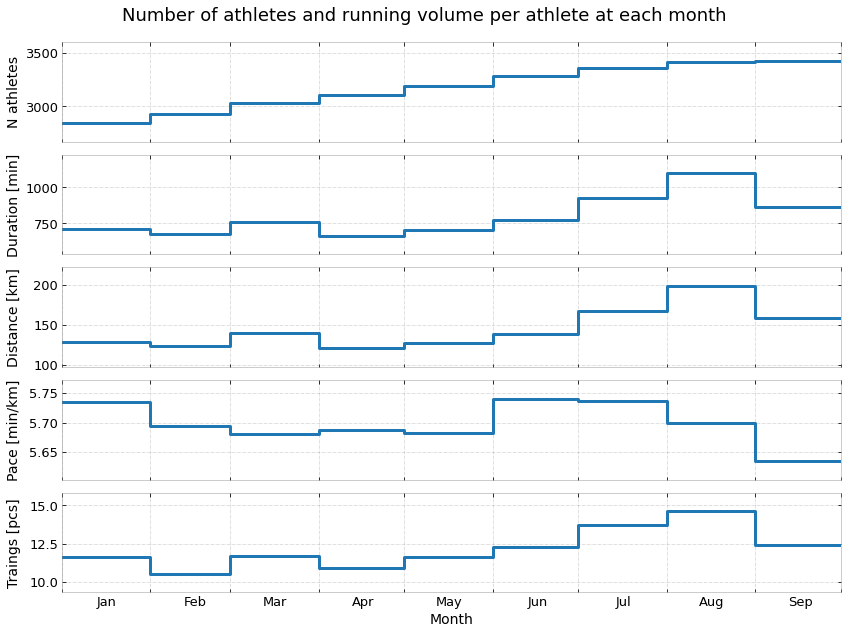

In [245]:
## lets plot the dynamics of training routines

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import matplotlib.colors

plt.rcParams.update({'font.size': 14, 'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

days = [31, 28, 31,30,31,30,31,31,30]
days_c = []
a=0
for i in days:
    a=a+i
    days_c.append(a)



fig, axs = plt.subplots(5, 1, sharex=True, figsize=(12, 9))
cols = z.columns
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','']
y_labels = ['N athletes','Duration [min]','Distance [km]','Pace [min/km]','Traings [pcs]']

for a, ax in enumerate(axs):
    ax.plot(np.append([0],z['period'].dt.dayofyear), 
            np.append(z[cols[a+1]],z[cols[a+1]][len(z[cols[a+1]])-1]), lw=3, drawstyle='steps-post')
    ax.margins(x=0, y=0.3)
    ax.tick_params(direction='in', axis='both', which='major', labelsize=13, top=True, right=True)
    ax.grid(b=True, which='major', color='gray', alpha=0.5, linestyle='-.', linewidth=0.5)
    ax.set_ylabel(y_labels[a])
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_alpha(0.5)
        #spine.linewidth(0.5)

axs[4].set_xlabel('Month')
axs[4].set_xticks(np.append([0],days_c))
axs[4].set_xticklabels(month, rotation=0, ha='center')
offset = matplotlib.transforms.ScaledTranslation(45/72, 0, fig.dpi_scale_trans)
for label in axs[4].get_xticklabels():
    label.set_transform(label.get_transform() + offset)

plt.suptitle('Number of athletes and running volume per athlete at each month', fontsize=18)
fig.align_ylabels(axs)
plt.tight_layout(h_pad=.5)
plt.savefig('dist_train_month.png')
plt.show()


In [246]:
## we can see that distance and duration have almost identical dynamics
## number of training persons are increasing towards the marathon date
## the volumes are decreasing in september due to time-off at the eve of the competition
## in summer monthes athletes increase distance reducing the pace

## Regression analysis 1

In [247]:
## here we will try to see if the marathon pace can be forecasted for any particular athlet 
## using her training data
## first we need to agregate the data for the analysis


reg1_db = pd.DataFrame()

reg1_db['athlete']       = marathon['athlete']
reg1_db['marathon_pace'] = marathon['pace']
reg1_db['gender']        = marathon['gender']
reg1_db['age_group']     = marathon['age_group']
reg1_db['tr_dist_tot']   = marathon['tr_dist_tot']
reg1_db['tr_num_tot']    = marathon['tr_num']
reg1_db['tr_mon']        = list(x['distance'].apply(lambda row : 9 - row.isna().sum(), axis=1).round(0))
reg1_db['tr_per_mon']    = (marathon['tr_num']/reg1_db['tr_mon']).round(1)
reg1_db['tr_pace_avg']   = marathon['tr_pace_avg']
reg1_db['tr_dist_avg']   = marathon['tr_dist_avg'].round(1)
reg1_db['tr_dist_mon']   = list(x['distance'].apply(lambda row : row.mean(), axis=1).round(1))
reg1_db['tr_dur_avg']    = (marathon['tr_dur_tot']/reg1_db['tr_num_tot']).round(1)

reg1_db.set_index('athlete',drop=True,inplace=True)

In [248]:
reg1_db.head()

,marathon_pace,gender,age_group,tr_dist_tot,tr_num_tot,tr_mon,tr_per_mon,tr_pace_avg,tr_dist_avg,tr_dist_mon,tr_dur_avg
athlete,,,,,,,,,,,
14,3.792462,M,35 - 54,2368.4,203,9,22.6,4.744807,11.7,263.2,55.4
30,5.364162,M,55 +,910.9,51,9,5.7,6.187287,17.9,101.2,110.5
69,6.236861,M,18 - 34,1086.6,111,9,12.3,5.960335,9.8,120.7,58.3
77,6.605762,M,35 - 54,1241.2,122,9,13.6,5.980342,10.2,137.9,60.8
102,7.407407,M,35 - 54,1066.0,136,9,15.1,8.012946,7.8,118.5,62.8


In [249]:
## need to think about filter on the number of months of trainings

reg1_db['tr_mon'].value_counts()
reg1_db=reg1_db[reg1_db['tr_mon']>4]

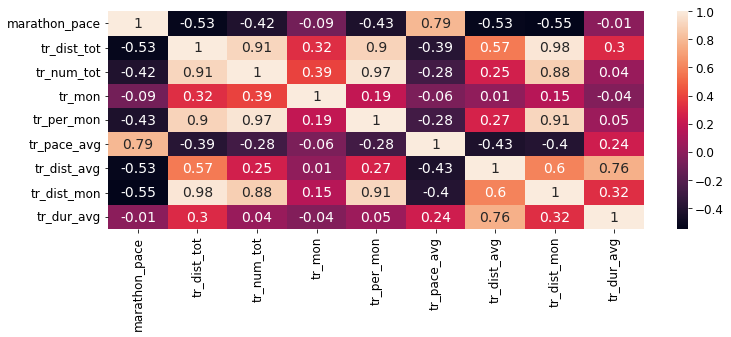

In [250]:
correlations_matrix = reg1_db.corr().round(2)

fig, axs = plt.subplots(1, sharex=True, figsize=(12, 4))
sns.heatmap(correlations_matrix, annot=True)
plt.show()

## We can see that marathon pace is strongly correlated with the average training pace
## There is evident positive correlation between measures of distances and number of training/durations
## Those variables are weakly negatively correlated with marathon pace, which in fact may reflect
## second order depency (and multicolinearity) between amount of running and pace.


In [251]:
## selecting numeric data and doing some transformations

reg1_db_num=reg1_db.drop('marathon_pace', axis=1)._get_numeric_data()

from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(reg1_db_num)
cols = reg1_db_num.columns
reg1_db_num_trans = transformer.transform(reg1_db_num)
reg1_db_num_trans = pd.DataFrame(reg1_db_num_trans, columns = cols)
reg1_db_num_trans.set_index(reg1_db.index,drop=True,inplace=True)
reg1_db_num_trans.head()

,tr_dist_tot,tr_num_tot,tr_mon,tr_per_mon,tr_pace_avg,tr_dist_avg,tr_dist_mon,tr_dur_avg
athlete,,,,,,,,
14,1.465672,1.814194,0.503115,1.800913,-1.364688,0.069279,1.439650,-0.798055
30,-0.346858,-1.261505,0.503115,-1.453215,0.757884,2.400787,-0.453856,3.129873
69,-0.034779,0.261726,0.503115,0.175335,0.496763,-0.768420,-0.123061,-0.541941
77,0.207081,0.480971,0.503115,0.422136,0.520649,-0.585675,0.132408,-0.327378
102,-0.069115,0.743371,0.503115,0.688009,2.276022,-1.743813,-0.157971,-0.159610


In [252]:
## same for categoricals

reg1_db_cat=reg1_db[['gender','age_group']]

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first') 
encoder.fit(reg1_db_cat)
reg1_db_cat_encoded = encoder.transform(reg1_db_cat).toarray()
cols = encoder.get_feature_names_out(input_features=reg1_db_cat.columns)
reg1_db_cat_encoded = pd.DataFrame(reg1_db_cat_encoded, columns=cols)

reg1_db_cat_encoded.set_index(reg1_db.index,drop=True,inplace=True)
reg1_db_cat_encoded.head()



,gender_M,age_group_35 - 54,age_group_55 +
athlete,,,
14,1.0,1.0,0.0
30,1.0,0.0,1.0
69,1.0,0.0,0.0
77,1.0,1.0,0.0
102,1.0,1.0,0.0


In [253]:
reg1_db_mod = pd.concat([reg1_db_cat_encoded, reg1_db_num], axis=1)
reg1_db_mod.columns

Index(['gender_M', 'age_group_35 - 54', 'age_group_55 +', 'tr_dist_tot',
       'tr_num_tot', 'tr_mon', 'tr_per_mon', 'tr_pace_avg', 'tr_dist_avg',
       'tr_dist_mon', 'tr_dur_avg'],
      dtype='object')

the intercept: -0.49
the coefficients: [1.05]
r2 score for training set: 0.64
r2 score for test set: 0.61


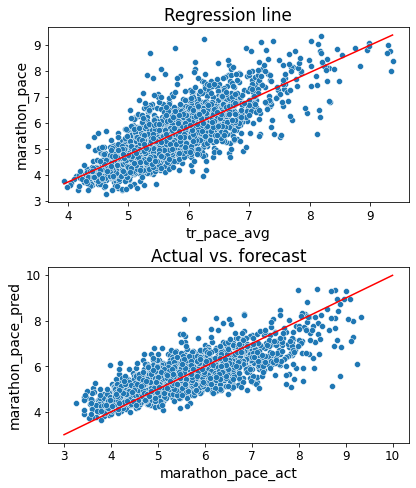

In [269]:
## lets check the most correlated variable first

y = reg1_db['marathon_pace']
X = reg1_db_mod[['tr_pace_avg']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

LR = linear_model.LinearRegression().fit(X_train,y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)
print('the intercept:',LR.intercept_.round(2))
print('the coefficients:',LR.coef_.round(2))
print('r2 score for training set:',r2_score(y_train,y_train_pred).round(2))
print('r2 score for test set:',r2_score(y_test,y_test_pred).round(2))

#X_train=X_train.values.tolist()

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(6, 7))

sns.scatterplot(ax = axs[0],x=X_train.values.ravel().tolist(),y=y_train)
X_plot = np.linspace(X_train.min(), X_train.max(), 100)
Y_plot = LR.intercept_+list(X_plot)*LR.coef_
axs[0].plot(X_plot, Y_plot, color='r')
axs[0].set_xlabel('tr_pace_avg')
axs[0].set_xlabel('tr_pace_avg')
axs[0].set_title('Regression line')

sns.scatterplot(ax = axs[1], x=list(y_train),y=list(y_train_pred))
X_plot = np.linspace(3, 10, 100)
Y_plot = X_plot
axs[1].plot(X_plot, Y_plot, color='r')
axs[1].set_xlabel('marathon_pace_act')
axs[1].set_ylabel('marathon_pace_pred')
axs[1].set_title('Actual vs. forecast')

plt.tight_layout(h_pad=.5)
plt.savefig('linear_regression.png')
plt.show()


In [255]:
## lets check all other variables

def super_regression(cols):
    df = reg1_db_mod
    y = reg1_db['marathon_pace']
    if len(cols)==1:
        X = df[cols].values.reshape(-1,1)
    else: X = df[cols]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    LR = linear_model.LinearRegression().fit(X_train,y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    
    return print(r2_score(y_train,y_train_pred).round(3),'for',cols)

regressors = [
    ['gender_M','tr_dist_avg','age_group_35 - 54', 'age_group_55 +'],
    ['gender_M','tr_dist_avg'],
    ['gender_M','tr_mon'],
    ['gender_M','tr_per_mon'],    
    ['gender_M','tr_dist_tot'],
    ['gender_M','tr_dist_tot','tr_dist_avg'],
    ['gender_M','tr_per_mon','tr_dist_avg','tr_mon'],
    ['gender_M','tr_per_mon','tr_dist_avg','tr_mon','age_group_35 - 54', 'age_group_55 +'],
    ['gender_M','tr_per_mon'],
    ['gender_M','tr_per_mon','tr_mon'],
    ['gender_M','tr_per_mon','tr_dist_avg'],
    ['tr_pace_avg'],
    ['tr_pace_avg','tr_dur_avg'],
    ['tr_pace_avg','tr_dist_mon'],
    ['tr_pace_avg','tr_dist_avg'],
    ['tr_pace_avg','gender_M'],
    ['tr_pace_avg','tr_per_mon'],
    ['tr_pace_avg','tr_per_mon','tr_dist_avg'],    
    ['tr_pace_avg','tr_per_mon','tr_dist_avg','tr_num_tot'],    
    ['tr_pace_avg','tr_num_tot','tr_dist_avg'], 
    ['tr_pace_avg','tr_per_mon','tr_dist_avg','tr_dist_tot','tr_mon','age_group_35 - 54', 'age_group_55 +']
            ]

for i in regressors:
    super_regression(i)
    
## We can again see that average training pace is the main factor affecting the marathon pace. 
## Interestingly 'gender' in presense of 'tr_pace_avg' does not affect the results
## Thist is probably because this factor is already reflected in the average pace for each individual.
## We believe that despite the clear dependency on the average training pace, it cannot be set as a kpi
## for an athlete trying to improve her marathon performance. Athletes are running at speeds that
## correspond to their individual aerobic abilities, and artificial increase of training pace can create 
## more problems than actually contribute to a new marathon PR.

0.355 for ['gender_M', 'tr_dist_avg', 'age_group_35 - 54', 'age_group_55 +']
0.325 for ['gender_M', 'tr_dist_avg']
0.104 for ['gender_M', 'tr_mon']
0.263 for ['gender_M', 'tr_per_mon']
0.345 for ['gender_M', 'tr_dist_tot']
0.404 for ['gender_M', 'tr_dist_tot', 'tr_dist_avg']
0.415 for ['gender_M', 'tr_per_mon', 'tr_dist_avg', 'tr_mon']
0.45 for ['gender_M', 'tr_per_mon', 'tr_dist_avg', 'tr_mon', 'age_group_35 - 54', 'age_group_55 +']
0.263 for ['gender_M', 'tr_per_mon']
0.263 for ['gender_M', 'tr_per_mon', 'tr_mon']
0.415 for ['gender_M', 'tr_per_mon', 'tr_dist_avg']
0.639 for ['tr_pace_avg']
0.682 for ['tr_pace_avg', 'tr_dur_avg']
0.696 for ['tr_pace_avg', 'tr_dist_mon']
0.684 for ['tr_pace_avg', 'tr_dist_avg']
0.64 for ['tr_pace_avg', 'gender_M']
0.676 for ['tr_pace_avg', 'tr_per_mon']
0.711 for ['tr_pace_avg', 'tr_per_mon', 'tr_dist_avg']
0.711 for ['tr_pace_avg', 'tr_per_mon', 'tr_dist_avg', 'tr_num_tot']
0.71 for ['tr_pace_avg', 'tr_num_tot', 'tr_dist_avg']
0.714 for ['tr_pace_avg

The R2 of the k-NN model is 0.49
The R2 of the k-nn model with 2 neighbours on the TEST set was: 0.37
The R2 of the k-nn model with 3 neighbours on the TEST set was: 0.43
The R2 of the k-nn model with 4 neighbours on the TEST set was: 0.45
The R2 of the k-nn model with 5 neighbours on the TEST set was: 0.47
The R2 of the k-nn model with 6 neighbours on the TEST set was: 0.48
The R2 of the k-nn model with 7 neighbours on the TEST set was: 0.49
The R2 of the k-nn model with 8 neighbours on the TEST set was: 0.50
The R2 of the k-nn model with 9 neighbours on the TEST set was: 0.50
The R2 of the k-nn model with 10 neighbours on the TEST set was: 0.51
The R2 of the k-nn model with 11 neighbours on the TEST set was: 0.51
The R2 of the k-nn model with 12 neighbours on the TEST set was: 0.51
The R2 of the k-nn model with 13 neighbours on the TEST set was: 0.51
The R2 of the k-nn model with 14 neighbours on the TEST set was: 0.52


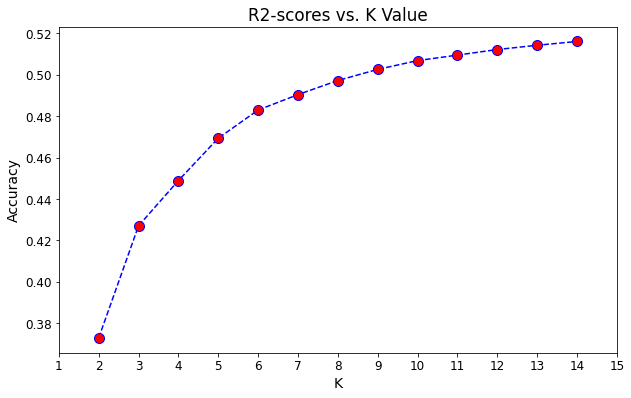

End
The R2 of the k-NN model is 0.56
The R2 of the k-nn model with 2 neighbours on the TEST set was: 0.52
The R2 of the k-nn model with 3 neighbours on the TEST set was: 0.56
The R2 of the k-nn model with 4 neighbours on the TEST set was: 0.58
The R2 of the k-nn model with 5 neighbours on the TEST set was: 0.61
The R2 of the k-nn model with 6 neighbours on the TEST set was: 0.63
The R2 of the k-nn model with 7 neighbours on the TEST set was: 0.63
The R2 of the k-nn model with 8 neighbours on the TEST set was: 0.64
The R2 of the k-nn model with 9 neighbours on the TEST set was: 0.63
The R2 of the k-nn model with 10 neighbours on the TEST set was: 0.64
The R2 of the k-nn model with 11 neighbours on the TEST set was: 0.64
The R2 of the k-nn model with 12 neighbours on the TEST set was: 0.64
The R2 of the k-nn model with 13 neighbours on the TEST set was: 0.64
The R2 of the k-nn model with 14 neighbours on the TEST set was: 0.64


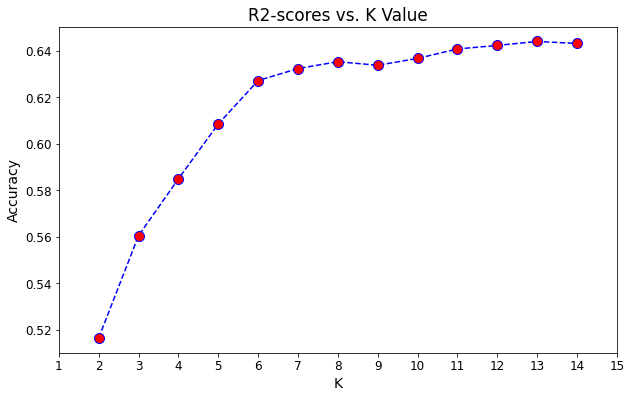

End
The R2 of the k-NN model is 0.50
The R2 of the k-nn model with 2 neighbours on the TEST set was: 0.46
The R2 of the k-nn model with 3 neighbours on the TEST set was: 0.49
The R2 of the k-nn model with 4 neighbours on the TEST set was: 0.52
The R2 of the k-nn model with 5 neighbours on the TEST set was: 0.53
The R2 of the k-nn model with 6 neighbours on the TEST set was: 0.53
The R2 of the k-nn model with 7 neighbours on the TEST set was: 0.53
The R2 of the k-nn model with 8 neighbours on the TEST set was: 0.53
The R2 of the k-nn model with 9 neighbours on the TEST set was: 0.53
The R2 of the k-nn model with 10 neighbours on the TEST set was: 0.53
The R2 of the k-nn model with 11 neighbours on the TEST set was: 0.53
The R2 of the k-nn model with 12 neighbours on the TEST set was: 0.52
The R2 of the k-nn model with 13 neighbours on the TEST set was: 0.52
The R2 of the k-nn model with 14 neighbours on the TEST set was: 0.52


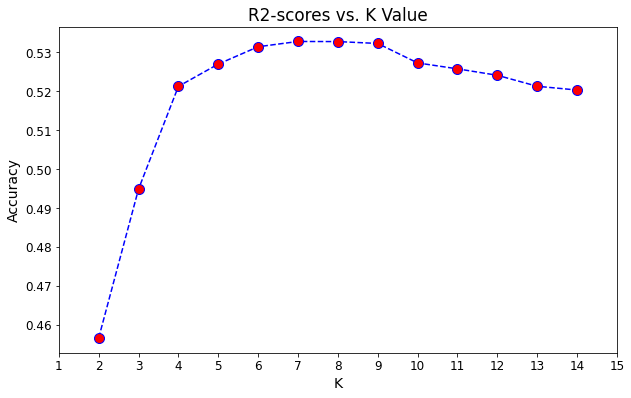

End


In [282]:
def super_knn_regression2(cols):
    
    db=reg1_db_mod
    y = reg1_db['marathon_pace']
    if len(cols)==1:
        X = db[cols].values.reshape(-1,1)
    else: X = db[cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    knn = KNeighborsRegressor(n_neighbors=3)
    knn.fit(X_train, y_train)   
    
    knn_score = knn.score(X_test, y_test)
    print("The R2 of the k-NN model is {:.2f}".format(knn_score))
    
    # a loop :
    knn_models = []  #empty list to store every knn models
    scores = []
    for k in range(2,15):
        model = KNeighborsRegressor(n_neighbors=k, weights='distance')
        model.fit(X_train, y_train)
        knn_models.append(model)
        scores.append(model.score(X_test, y_test))

    # then evaluate the score for each k :
    for index,score in enumerate(scores):
        print("The R2 of the k-nn model with {} neighbours on the TEST set was: {:.2f}".format(index+2,score))

    plt.figure(figsize=(10,6))
    plt.plot(range(2,15),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
    plt.title('R2-scores vs. K Value')
    plt.xticks(range(1,16))
    plt.xlabel('K')
    plt.ylabel('Accuracy')  
    plt.show()
                  
    print('End')
    return 


regressors = [['tr_pace_avg'],
              ['tr_pace_avg', 'tr_per_mon', 'tr_dist_avg'],
              ['tr_pace_avg', 'tr_dist_avg', 'tr_num_tot']

]

for i in regressors:
    super_knn_regression2(i)

#'5km_dist', '10km_dist', '15km_dist', '21km_dist',
#'5km_pace', '10km_pace', '15km_pace', '21km_pace',

## Regression analysis 2

In [256]:
## Lets try to find if the intensity of training can affect the marathon results. 

def distance_type(a):
    if a<6: return '5km'
    elif a<11: return '10km'
    elif a<16: return '15km'
    elif a<22: return '21km'
    else: return 'long'
train_db['dist_type']=train_db['distance'].apply(distance_type)

(train_db['dist_type'].value_counts()/train_db.shape[0]*100).round(2)


10km    40.15
15km    23.65
5km     14.58
21km    13.09
long     8.52
Name: dist_type, dtype: float64

In [257]:
reg2_db_pace=train_db[['athlete','dist_type','pace']].groupby(['athlete','dist_type']).mean().unstack(level=1).round(2)
reg2_db_pace.columns = reg2_db_pace.columns.droplevel()
reg2_db_pace=reg2_db_pace[['5km','10km','15km','21km','long']]
reg2_db_pace.head()

dist_type,5km,10km,15km,21km,long
athlete,,,,,
14,5.66,5.21,4.67,4.23,4.57
30,6.50,6.55,6.19,6.13,6.04
40,6.83,6.71,6.85,6.73,6.72
69,6.31,6.05,5.98,5.63,5.70
77,7.82,6.17,4.78,7.63,NaN


In [284]:
reg2_db_count = train_db[['athlete','dist_type','distance']].groupby(['athlete','dist_type']).count().unstack(level=1).round(2)
reg2_db_count.columns = reg2_db_count.columns.droplevel()
reg2_db_count=reg2_db_count[['5km','10km','15km','21km','long']]
reg2_db_count.head()

dist_type,5km,10km,15km,21km,long
athlete,,,,,
14,21.0,91.0,50.0,29.0,12.0
30,1.0,21.0,6.0,6.0,17.0
40,5.0,5.0,1.0,3.0,1.0
69,18.0,64.0,19.0,7.0,3.0
77,5.0,98.0,17.0,2.0,NaN


In [258]:
reg2_db_dist=train_db[['athlete','dist_type','distance']].groupby(['athlete','dist_type']).sum().unstack(level=1).round(2)
reg2_db_dist.columns = reg2_db_dist.columns.droplevel()
reg2_db_dist=reg2_db_dist[['5km','10km','15km','21km','long']].fillna(0)
reg2_db_dist.head()
reg2_db_dist.head()

dist_type,5km,10km,15km,21km,long
athlete,,,,,
14,84.39,777.73,664.62,527.67,313.99
30,3.68,199.71,82.49,111.14,513.90
40,25.37,31.09,13.87,59.95,25.00
69,73.32,558.39,240.14,139.52,75.20
77,21.89,957.82,218.85,42.66,0.00


In [259]:
reg2_db = reg2_db_pace.merge(reg2_db_dist, on='athlete', how = 'inner',suffixes=('_pace', '_dist')).copy()
reg2_db = reg2_db.merge(marathon[['athlete','tr_num','pace','tr_pace_avg','tr_dist_tot','gender']], on='athlete', how = 'inner').copy()

reg2_db = reg2_db[reg2_db['long_pace'].isna()==False]

reg2_db['5km_dist']  = ( reg2_db['5km_dist'].fillna(0)   ).round(2)
reg2_db['10km_dist'] = ( reg2_db['10km_dist'].fillna(0)  ).round(2)
reg2_db['15km_dist'] = ( reg2_db['15km_dist'].fillna(0)  ).round(2)
reg2_db['21km_dist'] = ( reg2_db['21km_dist'].fillna(0)  ).round(2)
reg2_db['long_dist'] = ( reg2_db['long_dist'].fillna(0)  ).round(2)

bin_std = pd.DataFrame(x['distance'].std(axis=1),columns=['std'])
reg2_db = reg2_db.merge(bin_std, on='athlete', how = 'inner').copy()
reg2_db = reg2_db[reg2_db['std'].isna()==False]

reg2_db['athlete'] = reg2_db['athlete'].astype('object')
reg2_db['gender'] = list(reg2_db['gender'].apply(lambda x: 1 if x=='F' else 0))


reg2_db.head()

#sns.pairplot(reg2_db)
#reg2_db.isna().sum()

,athlete,5km_pace,10km_pace,15km_pace,21km_pace,long_pace,5km_dist,10km_dist,15km_dist,21km_dist,long_dist,tr_num,pace,tr_pace_avg,tr_dist_tot,gender,std
0,14,5.66,5.21,4.67,4.23,4.57,84.39,777.73,664.62,527.67,313.99,203,3.792462,4.744807,2368.4,0,51.536732
1,30,6.50,6.55,6.19,6.13,6.04,3.68,199.71,82.49,111.14,513.90,51,5.364162,6.187287,910.9,0,34.258079
2,69,6.31,6.05,5.98,5.63,5.70,73.32,558.39,240.14,139.52,75.20,111,6.236861,5.960335,1086.6,0,72.492725
3,102,8.94,7.89,7.60,7.54,7.12,322.16,361.47,205.32,106.15,70.95,136,7.407407,8.012946,1066.0,0,32.701805
4,134,7.04,5.47,6.54,6.42,5.66,21.63,286.79,764.66,259.59,200.37,115,4.887218,6.218265,1533.0,0,74.938995


In [260]:
m5 = np.mean(reg2_db['5km_pace'])
reg2_db['5km_pace']=reg2_db['5km_pace'].fillna(m5)
m10 = np.mean(reg2_db['10km_pace'])
reg2_db['10km_pace']=reg2_db['10km_pace'].fillna(m10)
m15 = np.mean(reg2_db['15km_pace'])
reg2_db['15km_pace']=reg2_db['15km_pace'].fillna(m15)
m20 = np.mean(reg2_db['21km_pace'])
reg2_db['21km_pace']=reg2_db['21km_pace'].fillna(m20)
reg2_db.isna().sum().sum()

0

In [261]:
## introducing new variable - relative change of marathon pace vs average training pace.
## and dummifing it
reg2_db['pace_change'] =  -(reg2_db['pace']-reg2_db['long_pace'])/reg2_db['long_pace']
reg2_db['pace_change_cat'] = [1 if a>0 else 0 for a in reg2_db['pace_change']]

In [262]:
## also want to see if the rest period (in days) before the marathon affects the performance
from datetime import datetime

rest=pd.DataFrame()
rest['rest']=abs((train_db[['athlete','datetime']].groupby(['athlete']).max()-datetime.strptime('2019-09-29',"%Y-%m-%d")))
reg2_db=reg2_db.merge(rest, on='athlete', how = 'inner')
reg2_db['rest']=reg2_db['rest'].dt.days
reg2_db.head(5)

,athlete,5km_pace,10km_pace,15km_pace,21km_pace,long_pace,5km_dist,10km_dist,15km_dist,21km_dist,long_dist,tr_num,pace,tr_pace_avg,tr_dist_tot,gender,std,pace_change,pace_change_cat,rest
0,14,5.66,5.21,4.67,4.23,4.57,84.39,777.73,664.62,527.67,313.99,203,3.792462,4.744807,2368.4,0,51.536732,0.170140,1,2
1,30,6.50,6.55,6.19,6.13,6.04,3.68,199.71,82.49,111.14,513.90,51,5.364162,6.187287,910.9,0,34.258079,0.111894,1,6
2,69,6.31,6.05,5.98,5.63,5.70,73.32,558.39,240.14,139.52,75.20,111,6.236861,5.960335,1086.6,0,72.492725,-0.094186,0,1
3,102,8.94,7.89,7.60,7.54,7.12,322.16,361.47,205.32,106.15,70.95,136,7.407407,8.012946,1066.0,0,32.701805,-0.040366,0,1
4,134,7.04,5.47,6.54,6.42,5.66,21.63,286.79,764.66,259.59,200.37,115,4.887218,6.218265,1533.0,0,74.938995,0.136534,1,3


In [299]:
reg2_db['pace_change_cat'].value_counts()/reg2_db.shape[0]

1    0.731416
0    0.268584
Name: pace_change_cat, dtype: float64

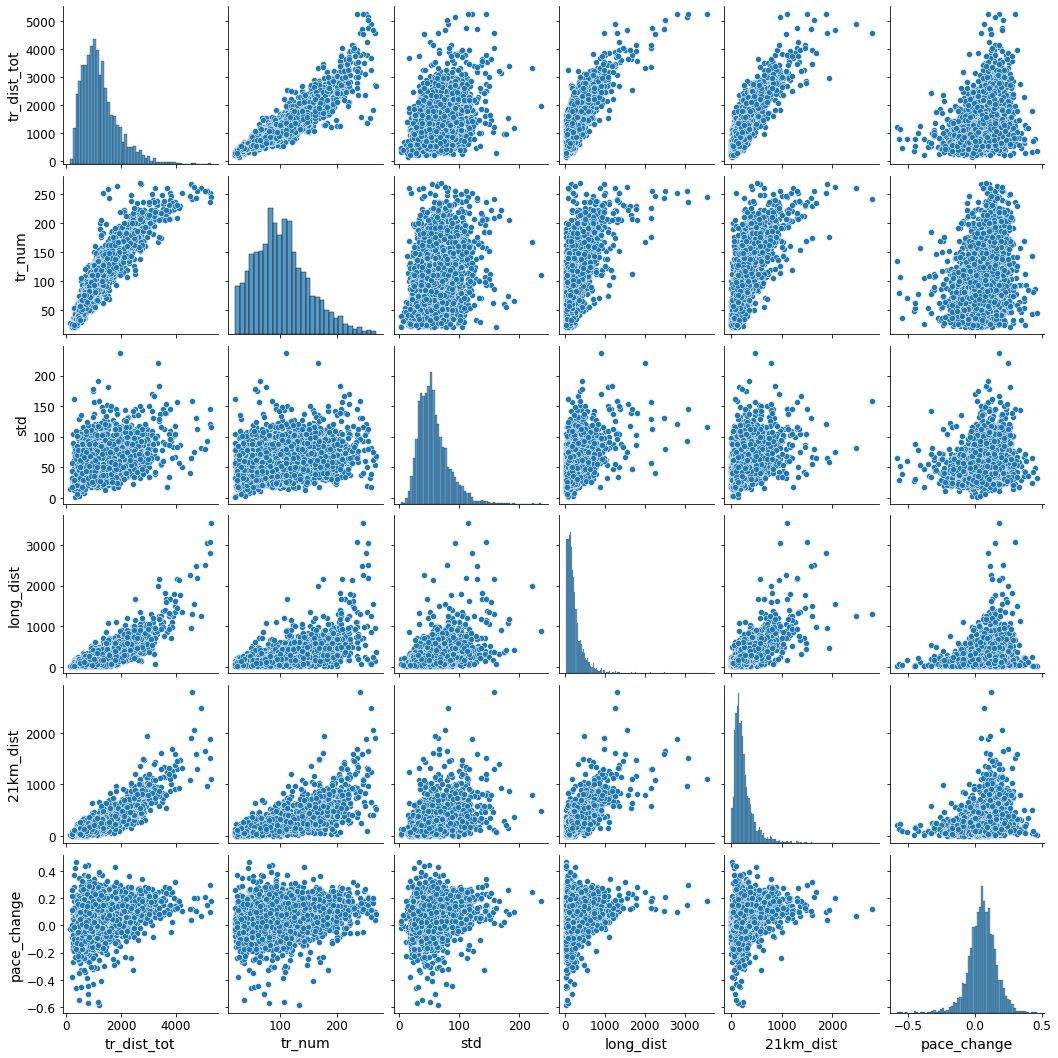

In [263]:
sns.pairplot(reg2_db[['tr_dist_tot', 'tr_num', 'std', 'long_dist','21km_dist','pace_change']])

## we can see that the change of speed is almost always positive for the participants with
## high intencity (distance) and variability (stdev of training length).

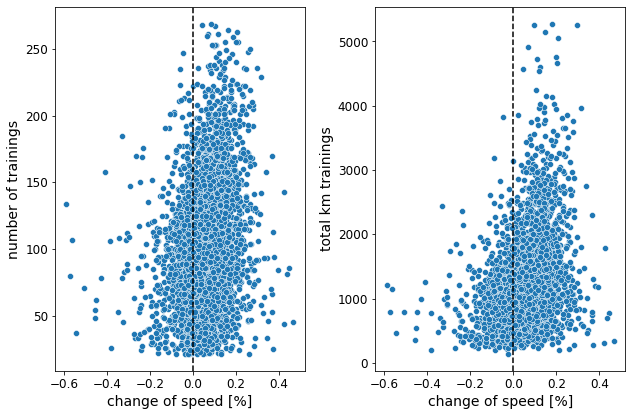

In [312]:
fig, axs = plt.subplots(1, 2, sharex=False, figsize=(9, 6))

sns.scatterplot(ax = axs[0],x=reg2_db['pace_change'],y=reg2_db['tr_num'])
axs[0].set_xlabel('change of speed [%]')
axs[0].set_ylabel('number of trainings')
l1=axs[0].axvline(0,color='black',ls='--')


sns.scatterplot(ax = axs[1],x=reg2_db['pace_change'],y=reg2_db['tr_dist_tot'])
axs[1].set_xlabel('change of speed [%]')
axs[1].set_ylabel('total km trainings')
l1=axs[1].axvline(0,color='black',ls='--')

plt.tight_layout(h_pad=.5)
plt.savefig('high_mileage.png')
plt.show()

## interestingly that for high mileage and variability of training the change of pace 
## is almost allways positive

In [296]:
transformer = PowerTransformer(method='yeo-johnson')
transformer.fit(reg2_db)
cols = reg2_db.columns
reg2_db_trans = transformer.transform(reg2_db)
reg2_db_trans = pd.DataFrame(reg2_db_trans, columns = cols)
reg2_db_trans.set_index(reg2_db.index,drop=True,inplace=True)
reg2_db_trans.head()

def super_regression(cols):
  
    db=reg2_db_trans
    y = db['pace']
    if len(cols)==1:
        X = db[cols].values.reshape(-1,1)
    else: X = db[cols]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    LR = linear_model.LinearRegression().fit(X_train,y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    
    return print(r2_score(y_train,y_train_pred).round(3),'for',cols)

regressors = [['15km_dist'],
              ['5km_dist','15km_dist'],
              ['5km_dist','long_dist','15km_dist'],
              ['5km_dist','10km_dist','15km_dist','21km_dist','long_dist'],
              ['5km_pace','10km_pace','15km_pace','21km_pace','long_pace'],
              ['long_dist','long_pace'],
              ['long_dist','long_pace','5km_pace'],
              ['long_dist','long_pace','tr_dist_tot'],
              ['long_dist','long_pace'],   
              ['long_dist','long_pace','5km_pace','rest','std'],  
              ['long_dist','long_pace','gender','5km_pace'],
              ['long_pace'],
              ['tr_pace_avg'],
              ['long_pace','tr_dist_tot'],
              ['tr_dist_tot'],
              ['std','tr_pace_avg'],
              ['rest'],
              ['5km_dist','10km_dist','15km_dist','21km_dist','long_dist',
        '5km_pace','10km_pace','15km_pace','21km_pace','long_pace', 
        'rest','std', 'tr_dist_tot']
            
             ]

for i in regressors:
    super_regression(i)

    
## clustering of training session by distance does not seems to provide any meaningful input for our analysis.
## interestingly the rest period can reduce the noice in the presense of other more meaningfull variables.

0.282 for ['15km_dist']
0.303 for ['5km_dist', '15km_dist']
0.361 for ['5km_dist', 'long_dist', '15km_dist']
0.37 for ['5km_dist', '10km_dist', '15km_dist', '21km_dist', 'long_dist']
0.67 for ['5km_pace', '10km_pace', '15km_pace', '21km_pace', 'long_pace']
0.687 for ['long_dist', 'long_pace']
0.689 for ['long_dist', 'long_pace', '5km_pace']
0.692 for ['long_dist', 'long_pace', 'tr_dist_tot']
0.687 for ['long_dist', 'long_pace']
0.697 for ['long_dist', 'long_pace', '5km_pace', 'rest', 'std']
0.695 for ['long_dist', 'long_pace', 'gender', '5km_pace']
0.64 for ['long_pace']
0.635 for ['tr_pace_avg']
0.681 for ['long_pace', 'tr_dist_tot']
0.264 for ['tr_dist_tot']
0.671 for ['std', 'tr_pace_avg']
0.035 for ['rest']
0.736 for ['5km_dist', '10km_dist', '15km_dist', '21km_dist', 'long_dist', '5km_pace', '10km_pace', '15km_pace', '21km_pace', 'long_pace', 'rest', 'std', 'tr_dist_tot']


## Regression analysis 3

Resampled dataset shape 1234


/Users/ttrofff/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Columns: ['5km_pace', '10km_pace', '15km_pace', '21km_pace', 'long_pace', '5km_dist', '10km_dist', '15km_dist', '21km_dist', 'long_dist', 'tr_num', 'tr_pace_avg', 'tr_dist_tot', 'gender', 'rest', 'std'] 

Classification report for train set:

              precision    recall  f1-score   support

      slower       0.64      0.70      0.67       617
      faster       0.67      0.61      0.64       617

    accuracy                           0.65      1234
   macro avg       0.66      0.65      0.65      1234
weighted avg       0.66      0.65      0.65      1234

Classification report for test set:

              precision    recall  f1-score   support

      slower       0.40      0.70      0.51       261
      faster       0.85      0.61      0.71       720

    accuracy                           0.64       981
   macro avg       0.62      0.66      0.61       981
weighted avg       0.73      0.64      0.66       981



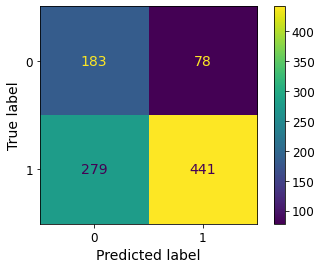

End


In [265]:
## Lets see if we can forecast the change in speed as increase(1)/decrease(0) with incorporated categorical
## variable (above).
## Logistics regression with undersampling:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
    
def super_classification_regression(cols):
    
    db=reg2_db
    y = db['pace_change_cat']
    if len(cols)==1:
        X = db[cols].values.reshape(-1,1)
    else: X = db[cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    y_train[y_train == 0].shape
    rus = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % len(y_train_under))
    
    logreg = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr',class_weight = 'balanced')
    logreg.fit(X_train_under, y_train_under)
    
    y_train_pred = logreg.predict(X_train_under)
    y_test_pred = logreg.predict(X_test)
    
    print('\nColumns:',i,'\n')
    print('Classification report for train set:\n')
    print(classification_report(y_train_under, y_train_pred, target_names=['slower','faster']))
    print('Classification report for test set:\n')
    print(classification_report(y_test, y_test_pred, target_names=['slower','faster']))
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(cm_test,display_labels=logreg.classes_)
    disp.plot()
    plt.show()
    print('End')
    return 


regressors = [['5km_pace', '10km_pace', '15km_pace', '21km_pace',
       'long_pace', '5km_dist', '10km_dist', '15km_dist', '21km_dist',
       'long_dist', 'tr_num', 'tr_pace_avg', 'tr_dist_tot', 'gender', 'rest',
       'std'],          
]

for i in regressors:
    super_classification_regression(i)
    
## The model gives right results in ~70% of cases. Seems to be comparable to our linear regression.

Resampled dataset shape 1234
The R2 of the k-NN model is 0.68
The R2 of the k-nn model with 2 neighbours on the TEST set was: 0.64
The R2 of the k-nn model with 3 neighbours on the TEST set was: 0.68
The R2 of the k-nn model with 4 neighbours on the TEST set was: 0.67
The R2 of the k-nn model with 5 neighbours on the TEST set was: 0.69
The R2 of the k-nn model with 6 neighbours on the TEST set was: 0.70
The R2 of the k-nn model with 7 neighbours on the TEST set was: 0.70
The R2 of the k-nn model with 8 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 9 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 10 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 11 neighbours on the TEST set was: 0.72
The R2 of the k-nn model with 12 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 13 neighbours on the TEST set was: 0.73
The R2 of the k-nn model with 14 neighbours on the TEST set was: 0.72


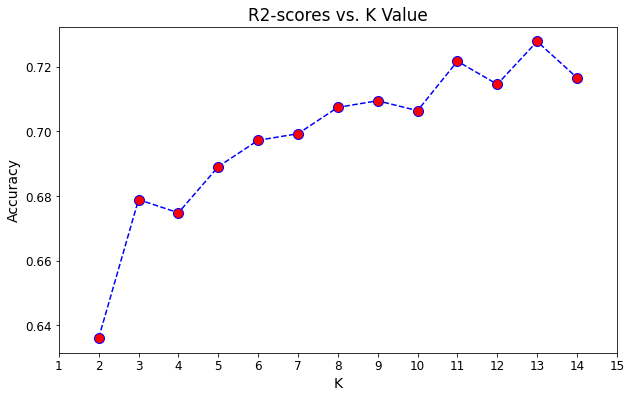

End
Resampled dataset shape 1234
The R2 of the k-NN model is 0.69
The R2 of the k-nn model with 2 neighbours on the TEST set was: 0.64
The R2 of the k-nn model with 3 neighbours on the TEST set was: 0.69
The R2 of the k-nn model with 4 neighbours on the TEST set was: 0.69
The R2 of the k-nn model with 5 neighbours on the TEST set was: 0.69
The R2 of the k-nn model with 6 neighbours on the TEST set was: 0.69
The R2 of the k-nn model with 7 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 8 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 9 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 10 neighbours on the TEST set was: 0.72
The R2 of the k-nn model with 11 neighbours on the TEST set was: 0.71
The R2 of the k-nn model with 12 neighbours on the TEST set was: 0.72
The R2 of the k-nn model with 13 neighbours on the TEST set was: 0.72
The R2 of the k-nn model with 14 neighbours on the TEST set was: 0.72


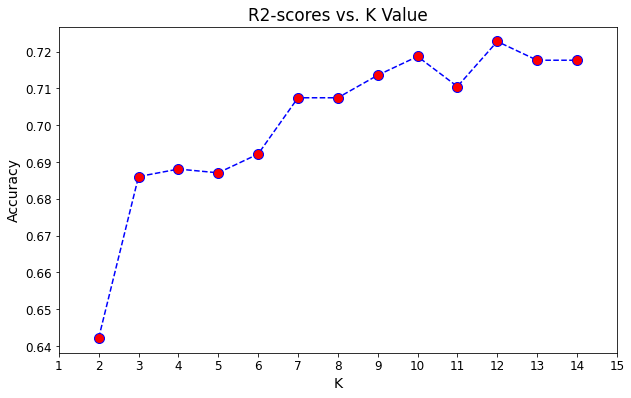

End


In [281]:
## KNN 

from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
    
def super_knn_regression(cols):
    
    db=reg2_db
    y = db[['pace_change_cat']].values.ravel()
    if len(cols)==1:
        X = db[cols].values.reshape(-1,1)
    else: X = db[cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    y_train[y_train == 0].shape
    rus = RandomUnderSampler(random_state=42)
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % len(y_train_under))
    
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)   
    
    knn_score = knn.score(X_test, y_test)
    print("The R2 of the k-NN model is {:.2f}".format(knn_score))
    
    
    # a loop :
    knn_models = []  #empty list to store every knn models
    scores = []
    for k in range(2,15):
        model = KNeighborsClassifier(n_neighbors=k, weights='distance')
        model.fit(X_train, y_train)
        knn_models.append(model)
        scores.append(model.score(X_test, y_test))

    # then evaluate the score for each k :
    for index,score in enumerate(scores):
        print("The accuracy of the k-nn model with {} neighbours on the TEST set was: {:.2f}".format(index+2,score))

    plt.figure(figsize=(10,6))
    plt.plot(range(2,15),scores,color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
    plt.title('Accuracy vs. K Value')
    plt.xticks(range(1,16))
    plt.xlabel('K')
    plt.ylabel('Accuracy')  
    plt.show()
                  
    print('End')
    return 


regressors = [[
       'long_pace', 
       'long_dist', 'tr_num', 'tr_pace_avg', 'tr_dist_tot', 'gender',
       'std','rest'],
              ['5km_pace','long_pace', 'tr_num', 'tr_pace_avg', 'tr_dist_tot', 'gender',
       'std','rest']
]

for i in regressors:
    super_knn_regression(i)

#'5km_dist', '10km_dist', '15km_dist', '21km_dist',
#'5km_pace', '10km_pace', '15km_pace', '21km_pace',